In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import ipywidgets as widgets
from IPython.display import clear_output

In [2]:
def delayer(input_beam:complex, input_power:float, length:float=1, wavelength:float=3) -> complex:
    """------------------------------------------------------------------------
    De-phase the input beam by heating the fiber with an electrical current.
    ### Parameters:
    - beam: Input beam complex amplitude
    - power: Input power in Watts
    - length: Fiber length in milimeters
    - wavelength: Wavelength in microns
    ### Returns:
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    # TODO

    return input_beam * np.exp(1j*input_power*np.pi)

def mach_zehnder(beam:complex, power:float) -> complex:
    """------------------------------------------------------------------------
    Partially or totally cancel the light of a beam by
    splitting it in two part, dephasing one path and recombining them.
    ### Parameters:
    - input_beam: Input beam complex amplitude
    - input_power: Input power in Watts for the dephasing.
    ### Returns:
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    return beam + delayer(beam, power)

def random_phase_pertubation(beam:complex, rms:float) -> complex:
    """------------------------------------------------------------------------
    Add a random phase pertubation to the input beam.
    ### Parameters:
    - beam: Input beam complex amplitude
    - rms: Root mean square of the phase pertubation in radians
    ### Returns:
    - Output beam complex amplitude
    ------------------------------------------------------------------------"""

    return beam * np.exp(1j * np.random.normal(scale=rms))

def dot(M,x):
    """------------------------------------------------------------------------
    Compute the dot product of a matrix and a vector.
    ### Parameters:
    - M: Matrix (2D array)
    - x: Vector (1D array)
    ### Returns:
    - Resulting vector (1D array)
    ------------------------------------------------------------------------"""

    M = np.array(M)
    x = np.array(x)
    y = np.zeros((M.shape[0],*x.shape[1:]), dtype=complex)

    for row in range(M.shape[0]):
        for col in range(M.shape[1]):
            y[row] += M[row][col] * x[col]

    return y

def nuller(beams:list[complex]) -> tuple[complex, list[complex]]:
    """------------------------------------------------------------------------
    Simulate a 4 input beam nuller.
    ### Parameters:
    - beams: List of input beams complex amplitudes
    ### Returns:
    - Bright channel complex amplitude
    - List of dark channels complex amplitudes
        --------------------------------------------------------------------"""

    N = 1/np.sqrt(4) * np.array([
        [1,  1,  1,  1],
        [1,  1, -1, -1],
        [1, -1,  1, -1],
        [1, -1, -1,  1]
    ])
    
    outputs = dot(N, beams)

    return outputs[0], outputs[1:]

def split_and_mix(beams:list[complex]) -> list[complex]:
    """------------------------------------------------------------------------
    Simulate a 3 input beam split and mix.
    ### Parameters:
    - beams: List of input beams complex amplitudes 
    ### Returns:
    - List of output beams complex amplitudes
        --------------------------------------------------------------------"""
    
    phi = np.pi/2
    S = 1/np.sqrt(4) * np.array([
        [1               , np.exp(1j*phi)  , 0             ],
        [-np.exp(-1j*phi), 1               , 0             ],
        [1               , 0               , np.exp(1j*phi)],
        [-np.exp(-1j*phi), 0               , 1             ],
        [0               , 1               , np.exp(1j*phi)],
        [0               , -np.exp(-1j*phi), 1             ]
    ])

    return dot(S, beams)

In [3]:
class KernelNullerV0:
    def __init__(self, IP:list[float], BP: float, NP:list[float], SP:list[float], phase_rms:float=0.1):
        """--------------------------------------------------------------------
        Create a 4 telescope Kernel-Nuller (version 0)
        ### Parameters:
        - IP: Input phase corrective power (list of 4 floats)
        - NP: Nuller phase corrective power (list of 3 floats)
        - SP: Split and mix phase corrective power (list of 6 floats)
        - phase_rms: Root mean square of the phase pertubation in radians
        --------------------------------------------------------------------"""

        assert len(IP) == 4, "IP must be a list of 4 floats"
        assert len(NP) == 3, "NP must be a list of 3 floats"
        assert len(SP) == 6, "SP must be a list of 6 floats"

        self.input_phase_corrective_powers = np.array(IP)
        self.nuller_bright_phase_corrective_power = BP
        self.nuller_dark_phase_corrective_powers = np.array(NP)
        self.splitmix_phase_corrective_powers = np.array(SP)

        self.phase_rms = phase_rms

        self.input_phase_aberrations = np.array([np.exp(1j * np.random.normal(scale=phase_rms)) for _ in range(4)])
        self.nuller_bright_phase_aberation = np.exp(1j * np.random.normal(scale=phase_rms))
        self.nuller_dark_phase_aberations = np.array([np.exp(1j * np.random.normal(scale=phase_rms)) for _ in range(3)])
        self.splitmix_phase_aberations = np.array([np.exp(1j * np.random.normal(scale=phase_rms)) for _ in range(6)])

    def __call__(self, ideal_input_beams:list[complex]) -> tuple[complex, list[complex]]:
        """--------------------------------------------------------------------
        Simulate a 4 telescope Kernel-Nuller propagation
        ### Parameters:
        - beams: List of input beams complex amplitudes (ideal)
        ### Returns:
        - Bright channel complex amplitude
        - List of dark channels complex amplitudes
        --------------------------------------------------------------------"""

        perturbed_input_beams = ideal_input_beams * self.input_phase_aberrations
        corrected_input_beams = delayer(perturbed_input_beams, self.input_phase_corrective_powers)

        ideal_nuller_bright_channel, ideal_nuller_dark_channels = nuller(corrected_input_beams)
        perturbed_nuller_bright_channel = ideal_nuller_bright_channel * self.nuller_bright_phase_aberation
        perturbed_nuller_dark_channels = ideal_nuller_dark_channels * self.nuller_dark_phase_aberations
        corrected_nuller_bright_channel = delayer(perturbed_nuller_bright_channel, self.nuller_bright_phase_corrective_power)
        corrected_nuller_dark_channels = delayer(perturbed_nuller_dark_channels, self.nuller_dark_phase_corrective_powers)

        ideal_splitmix_output_beams = split_and_mix(corrected_nuller_dark_channels)
        perturbed_splitmix_output_beams = ideal_splitmix_output_beams * self.splitmix_phase_aberations
        corrected_splitmix_output_beams = delayer(perturbed_splitmix_output_beams, self.splitmix_phase_corrective_powers)
        
        return corrected_nuller_bright_channel, corrected_splitmix_output_beams, {
            "input": corrected_input_beams,
            "nuller_dark": corrected_nuller_dark_channels
        }

In [4]:
kn0 = KernelNullerV0([0,0,0,0], 0, [0,0,0], [0,0,0,0,0,0], 0.1)

ideal_beams = np.array([
    1e11 + 0*np.exp(1j * 0.10),
    1e11 + 0*np.exp(1j * -0.12),
    1e11 + 0*np.exp(1j * 0.05),
    1e11 + 0*np.exp(1j * -0.01),
])

In [5]:
max_power = 1
step = 1e-14

IP1 = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Input 1')
IP2 = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Input 2')
IP3 = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Input 3')
IP4 = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Input 4')

NP0 = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Brithg')
NP1 = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Null 1')
NP2 = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Null 2')
NP3 = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Null 3')

SP1 = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Dark 1')
SP2 = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Dark 2')
SP3 = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Dark 3')
SP4 = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Dark 4')
SP5 = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Dark 5')
SP6 = widgets.FloatSlider(value=0, min=-max_power, max=max_power, step=step, description='Dark 6')

bright, darks, intermediate = kn0(ideal_beams)

def beam_state(beam:complex) -> str:
    return f"{np.abs(beam):.3e} * exp({np.angle(beam)/np.pi:.3e} pi)"   

Inputs = [widgets.Label(value=f" ") for _ in range(4)]
NullerDarks = [widgets.Label(value=f" ") for _ in range(3)]
Bright = widgets.Label(value=f" ")
Darks = [widgets.Label(value=f" ") for _ in range(6)]

def update(*args):
    kn0.input_phase_corrective_powers = np.array([IP1.value, IP2.value, IP3.value, IP4.value])
    kn0.nuller_bright_phase_corrective_power = NP0.value
    kn0.nuller_dark_phase_corrective_powers = np.array([NP1.value, NP2.value, NP3.value])
    kn0.splitmix_phase_corrective_powers = np.array([SP1.value, SP2.value, SP3.value, SP4.value, SP5.value, SP6.value])

    bright, darks, inter = kn0(ideal_beams)

    Bright.value = f"Bright: {beam_state(bright)}"
    for i, dark in enumerate(darks):
        Darks[i].value = f"Dark {i}: {beam_state(dark)}"
    for i, v in enumerate(inter['input']):
        Inputs[i].value = f"Input {i}: {beam_state(v)}"
    for i, v in enumerate(inter['nuller_dark']):
        NullerDarks[i].value = f"Nuller {i}: {beam_state(v)}"

    return bright, darks


for widget in [IP1, IP2, IP3, IP4, NP0, NP1, NP2, NP3, SP1, SP2, SP3, SP4, SP5, SP6]:
    widget.observe(update, 'value')

empty = widgets.Label()

widgets.VBox([
    widgets.Label("Input phase corrective powers:"),
    widgets.HBox([IP1, IP2, IP3, IP4]),
    *[widgets.HBox([x]) for x in Inputs],
    widgets.Label("Nuller phase corrective powers:"),
    widgets.HBox([NP0, NP1, NP2, NP3]),
    *[widgets.HBox([x]) for x in [Bright] + NullerDarks],
    widgets.Label("Split & Mix phase corrective powers:"),
    widgets.HBox([SP1, SP2, SP3]),
    widgets.HBox([SP4, SP5, SP6]),
    *[widgets.HBox([x]) for x in [Bright] + Darks],
])

Delta : 8.18e-15
Null : 1.39e-14


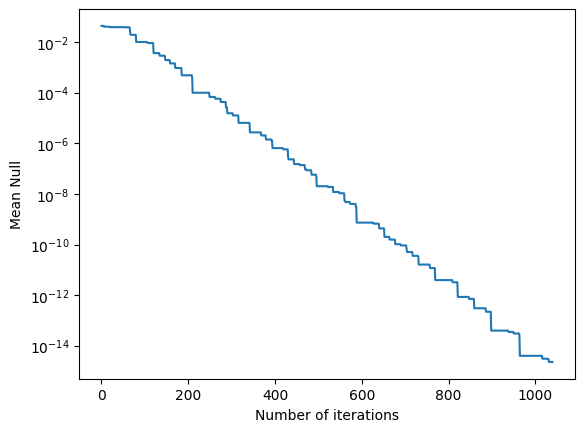

In [6]:
import time

delta = 1

msr = []

while delta > step:
    
    delta /= 1.5

    for p in [IP1, IP2, IP3, IP4, NP1, NP2, NP3, SP1, SP2, SP3, SP4, SP5, SP6]:

        old_bright, old_darks = update()

        p.value += delta
        pos_bright, pos_darks = update()

        p.value -= 2*delta
        neg_bright, neg_darks = update()

        p.value += delta

        old_null_mean = 0
        pos_null_mean = 0
        neg_null_mean = 0
        for old_dark, pos_dark, neg_dark in zip(old_darks, pos_darks, neg_darks):
            old_null_mean += (np.abs(old_dark) / np.abs(old_bright))
            pos_null_mean += (np.abs(pos_dark) / np.abs(pos_bright))
            neg_null_mean += (np.abs(neg_dark) / np.abs(neg_bright))

        msr.append(old_null_mean / len(old_darks))

        if pos_null_mean < old_null_mean and pos_null_mean < neg_null_mean:
            p.value += delta
        elif neg_null_mean < old_null_mean and neg_null_mean < pos_null_mean:
            p.value -= delta

    clear_output(wait=True)
    print(f"Delta : {delta:.2e}")
    print(f"Null : {old_null_mean:.2e}")
    # time.sleep(0.1)

plt.plot(msr)
plt.xlabel("Number of iterations")
plt.ylabel("Mean Null")
plt.yscale("log")
plt.show()